# Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image,ImageOps,ImageEnhance
import os
import math
import json
from io import StringIO
import skimage as ski
from skimage import data, io, filters

# Lectura de archivos

In [2]:
figuras = os.path.join('imagenes/foto.jpg')

In [3]:
figs_orig = Image.open(figuras)

# Analizamos los datos

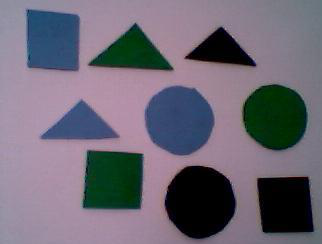

In [4]:
figs_orig

# Preprocesamiento de los datos
Convertimos primero la imagen a escala de grises.

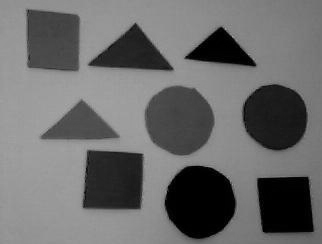

In [5]:
figs_grayscale = ImageOps.grayscale(figs_orig)
figs_grayscale

Aumentamos el contraste de la imagen

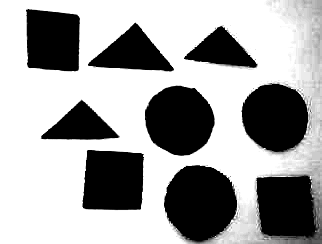

In [6]:
figs_grayscale = ImageEnhance.Contrast(figs_grayscale).enhance(8)
figs_grayscale

Binarizamos la imagen definiendo la función de binarización.

In [7]:
# Función de binarización
def umbral_image(img):
    x,y=img.shape
    z=np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            if img[i,j]>25:
                z[i,j]=255
    return z

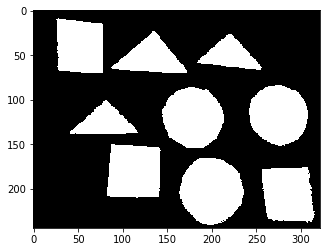

In [8]:
fig_arr = np.array(figs_grayscale)
fig_bin = umbral_image(fig_arr)
ICD=ski.util.invert(fig_bin)
plt.imshow(ICD,cmap='gray')
plt.show()

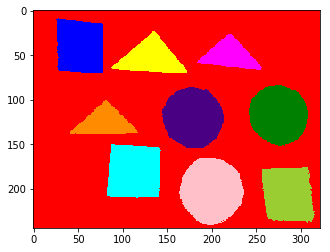

In [9]:
# Proceso para aplicar los Momentos de Hu
# Invertir los colores de la imagen
label_image=ski.measure.label(ICD)
plt.imshow(ski.color.label2rgb(label_image))
plt.show()

Se obtienen las regiones de la imagen original y se calculan las propiedades de cada región.

In [10]:
regions = ski.measure.regionprops(label_image)
for prop in regions[0]:
    print(prop,regions[0][prop])

area 52836
bbox (0, 0, 244, 322)
bbox_area 78568
centroid (116.01474373533198, 151.94479143008556)
convex_area 78568
convex_image [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
coords [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [243 319]
 [243 320]
 [243 321]]
eccentricity 0.6962732065160528
equivalent_diameter 259.37016903573755
euler_number -8
extent 0.672487526728439
filled_area 78568
filled_image [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
image [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  Tru

/home/ivanovsky/anaconda3/envs/tensorflowGPU/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ivanovsky/anaconda3/envs/tensorflowGPU/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


Imprimimos las regiones encontradas

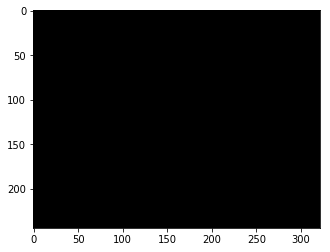

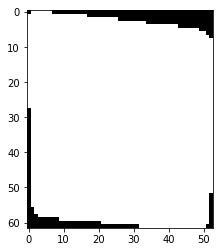

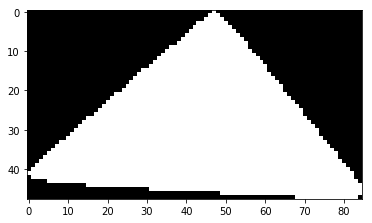

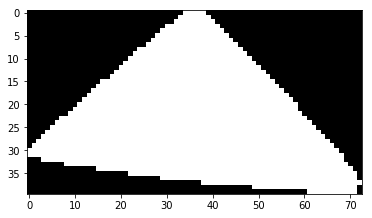

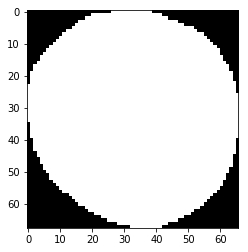

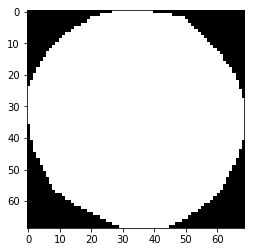

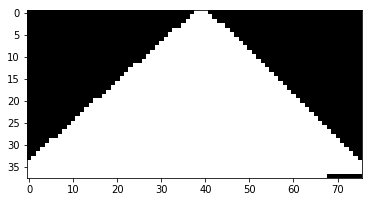

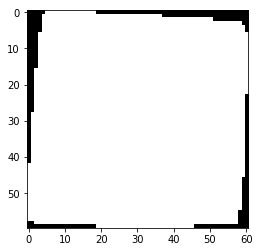

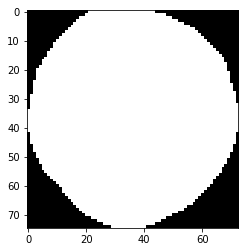

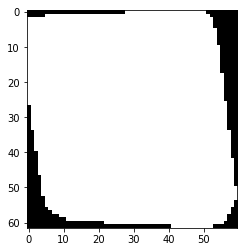

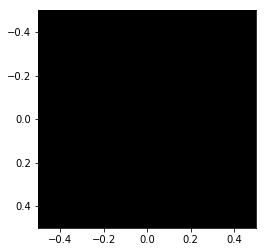

In [11]:
for region in regions:
    plt.imshow(region.convex_image,cmap='gray')
    plt.show()

Observamos que la primer y última región no son de utilidad, así que las desechamos

In [12]:
regions.pop(0)
regions.pop(9)

## Guardamos las imágenes a un archivo

### Para clasificación por forma

In [13]:
for num,region in enumerate(regions):
    
    # Creamos un arreglo vacio con las dimensiones de la región
    img = np.empty(region.convex_image.shape,dtype=np.uint8)
    
    for i in range(region.convex_image.shape[0]):
        for j in range(region.convex_image.shape[1]):
            
            # Creamos la imagen binarizada
            if region.convex_image[i,j]:
                img[i,j] = 255
            else:
                img[i,j] = 0
                
    io.imsave('imagenes/forma/train/Fig{0}.jpg'.format(num+1),img)

### Para clasificación por color

In [14]:
for num,region in enumerate(regions):
    
    # Leemos la figura original
    img = io.imread(figuras)
    # Obtenemos el color de la figura en el centroide de la región
    color = img[int(region.centroid[0]),int(region.centroid[1])]
    # Obtenemos la región de la imagen original
    img = img[region.bbox[0]:region.bbox[2],region.bbox[1]:region.bbox[3]]
    
    for i in range(region.convex_image.shape[0]):
        for j in range(region.convex_image.shape[1]):
            if region.convex_image[i,j]:
                img[i,j] = color
            else:
                img[i,j] = [255,255,255]
                
    io.imsave('imagenes/color/train/Fig{0}.jpg'.format(num+1),img)

## Definimos la función para extraer los Momentos de Hu

In [15]:
def hu_Characteristics(img):
    Iing=ski.util.invert(img)
    Uing=umbral_image(Iing)
    label_image=ski.measure.label(Uing)
    regions = ski.measure.regionprops(label_image)
    momento =regions[0].moments_hu
    return momento

## Definimos la función para extraer el color de la figura en su centro

In [16]:
def get_figure_color(img):
    dims = img.shape
    r,g,b = img[dims[0]//2,dims[1]//2]
    return r,g,b

## Preparando los datos para clasificación por forma

Se usará aprendizaje supervisado,los datos de entrenamiento consisten en pares ordenados donde hay una lista de entradas y una lista de salidas.

### Entradas
x = [x1,x2,x3,x4,x5,x6,x7] (Momentos de Hu)

### Salidas 

(Necesario codificarlas) 
- Cuadro = [1,0,0]
- Triángulo = [0,1,0]
- Círculo = [0,0,1]

y=[[1,0,0],[0,1,0],[0,0,1]]

## Definimos la función de lectura del conjunto de entrenamiento

In [17]:
def Lector_forma(Train_dir,jsonfile):
    Train_data=[]
    Tags=[]
    with open(jsonfile) as data_file:    
         etiquetas = json.load(data_file)
    for img in os.listdir(Train_dir):
        try : 
            imgtag=etiquetas[img]
            Tags.append(imgtag)
        except :
            print("Tag error: "+img)
        try : 
            imgpath=os.path.join(Train_dir,img)
            img = Image.open(imgpath).convert('L')
            Train_data.append(hu_Characteristics(np.array(img))) 
        except :
            print("file error: "+img)
        #np.save(file+".npy",Train_data)
    return np.array(Train_data),Tags 

In [18]:
X_train,y_train=Lector_forma("imagenes/forma/train/","train_forma.json")

In [19]:
X_train

array([[ 2.27897610e-01,  1.41303851e-02,  6.21972920e-03,
         3.53028351e-04, -8.06131364e-08, -1.56762488e-05,
        -5.16869937e-07],
       [ 2.25523019e-01,  1.36215181e-02,  5.74748838e-03,
         3.06064538e-04, -8.12861760e-08, -1.39565712e-05,
        -3.97715167e-07],
       [ 3.01997038e-01,  3.10037249e-02,  2.83112989e-02,
         3.28110117e-03, -6.56670438e-06, -2.64549581e-04,
        -3.09341456e-05],
       [ 1.36847693e+00,  1.83247565e+00,  9.18701843e-01,
         8.72216274e-01,  7.80769532e-01,  1.18009100e+00,
         1.41629128e-03],
       [ 2.23972580e-01,  1.30533339e-02,  5.65080061e-03,
         2.80452431e-04, -1.24011160e-07, -1.69456969e-05,
        -3.30559965e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.93726473e-01,  2.92261124e-02,  2.30139526e-02,
         2.09708309e-03, -8.84739433e-06, -2.65255789e-04,
        -1.1574495

# Clasificador de forma

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [21]:
clforma = MLPClassifier(solver='lbfgs', alpha=1e-2,
                  hidden_layer_sizes=(10, 3))

In [22]:
def ClassDetector(onehot):
    output=[]
    for caso in onehot:
        output.append(np.argmax(caso))
    return output

In [23]:
clforma.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [24]:
pred = clforma.predict(X_train)
print(pred)

[[0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


In [25]:
predclass=ClassDetector(pred)
yclass=ClassDetector(y_train)
print(predclass)
print(yclass)

[1, 1, 2, 0, 1, 0, 2, 0, 2]
[1, 1, 2, 0, 1, 0, 2, 0, 2]


In [26]:
print(accuracy_score(predclass,yclass)) 

1.0


In [27]:
print(confusion_matrix(predclass,yclass))

[[3 0 0]
 [0 3 0]
 [0 0 3]]


# Guardar el modelo

In [28]:
from sklearn.externals import joblib

In [29]:
filename = 'clforma_model.sav'
joblib.dump(clforma, filename)

['clforma_model.sav']

In [30]:
loaded_model = joblib.load(filename)

In [31]:
load_predict=loaded_model.predict(X_train)

In [32]:
ClassDetector(load_predict)

[1, 1, 2, 0, 1, 0, 2, 0, 2]

## Preparando los datos para clasificación por color

Se usará aprendizaje supervisado,los datos de entrenamiento consisten en pares ordenados donde hay una lista de entradas y una lista de salidas.

### Entradas
x=[r,g,b] (Color RGB de la figura en el centroide)

### Salidas 

(Necesario codificarlas) 
- Azul = [1,0,0]
- Verde = [0,1,0]
- Negro = [0,0,1]

y=[[1,0,0],[0,1,0],[0,0,1]]

In [33]:
def Lector_color(Train_dir,jsonfile):
    Train_data=[]
    Tags=[]
    with open(jsonfile) as data_file:    
         etiquetas = json.load(data_file)
    for img in os.listdir(Train_dir):
        try : 
            imgtag=etiquetas[img]
            Tags.append(imgtag)
        except :
            print("Tag error: "+img)
        try : 
            imgpath=os.path.join(Train_dir,img)
            img = Image.open(imgpath)
            Train_data.append(get_figure_color(np.array(img))) 
        except :
            print("file error: "+img)
        #np.save(file+".npy",Train_data)
    return np.array(Train_data),Tags 

In [34]:
X_train,y_train=Lector_color("imagenes/color/train/","train_color.json")

In [35]:
X_train

array([[  1,   1,   0],
       [  1,  59,  18],
       [  0,  42,   6],
       [  0,  56,  17],
       [ 62,  81, 123],
       [ 43,  77, 114],
       [ 51,  70, 110],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

# Clasificador de figuras por color

In [36]:
clcolor = MLPClassifier(solver='lbfgs', alpha=1e-2,
                  hidden_layer_sizes=(10, 3))

In [37]:
clcolor.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [38]:
pred = clcolor.predict(X_train)
print(pred)

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]


In [39]:
predclass=ClassDetector(pred)
yclass=ClassDetector(y_train)
print(predclass)
print(yclass)

[2, 1, 1, 1, 0, 0, 0, 2, 2]
[2, 1, 1, 1, 0, 0, 0, 2, 2]


In [40]:
print(accuracy_score(predclass,yclass)) 

1.0


In [41]:
print(confusion_matrix(predclass,yclass))

[[3 0 0]
 [0 3 0]
 [0 0 3]]


## Guardar el modelo

In [42]:
filename = 'clcolor_model.sav'
joblib.dump(clcolor, filename)

['clcolor_model.sav']

In [43]:
loaded_model = joblib.load(filename)

In [44]:
load_predict=loaded_model.predict(X_train)

In [45]:
ClassDetector(load_predict)

[2, 1, 1, 1, 0, 0, 0, 2, 2]